In [391]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature
import os
import numpy as np
import warnings
from geopy.distance import geodesic
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import networkx as nx


warnings.filterwarnings('ignore')


In [392]:
airbnbs_df = pd.read_csv("AB_US_2023.csv")

In [393]:
coords = np.radians(airbnbs_df[['latitude', 'longitude']])

kms_per_radian = 6371.0088
epsilon = 0.7 / kms_per_radian  # 0.5 km neighborhood

db = DBSCAN(eps=epsilon, min_samples=50, algorithm='ball_tree', metric='haversine')
airbnbs_df['cluster'] = db.fit_predict(coords)
airbnbs_df = airbnbs_df[airbnbs_df["cluster"] != -1]

Next up, let's compute cluster centroids as the mean of the latitude and longitude values for each group.

In [394]:
airbnbs_df['latitude_deg'] = np.degrees(coords["latitude"])
airbnbs_df['longitude_deg'] = np.degrees(coords["longitude"])
cluster_centers = airbnbs_df.groupby('cluster')[['latitude_deg', 'longitude_deg']].mean().reset_index()

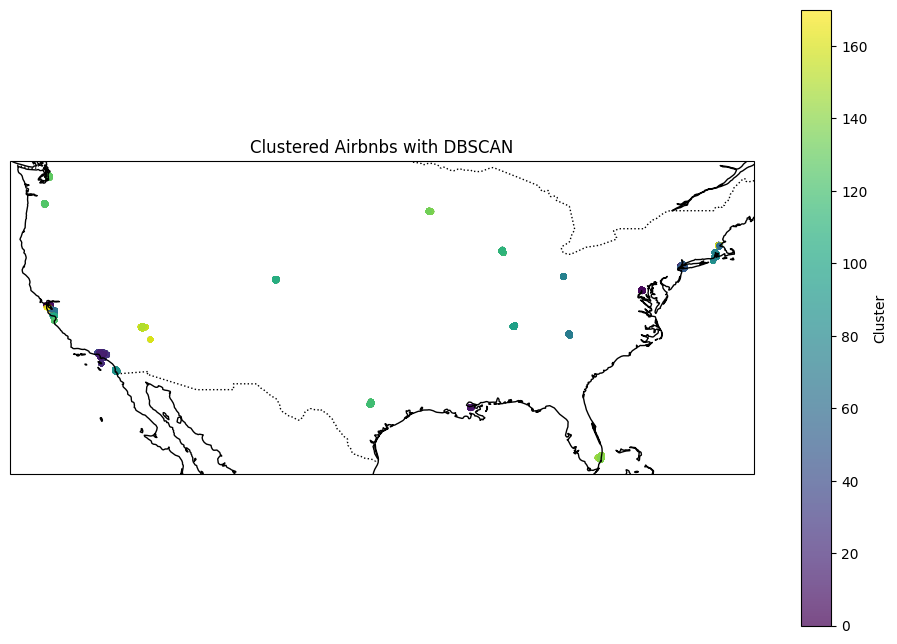

In [395]:
# Plotting the clusters on a map with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Add features to the map
ax.set_title("Clustered Airbnbs with DBSCAN")
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')

# Scatter the points, color them by cluster
scatter = ax.scatter(
    airbnbs_df['longitude'], airbnbs_df['latitude'], c=airbnbs_df['cluster'], 
    cmap='viridis', s=10, transform=ccrs.PlateCarree(), alpha=0.7
)

# Add a colorbar to indicate the cluster labels
plt.colorbar(scatter, ax=ax, label='Cluster')

# Show the plot
plt.show()


Seems like the clustering worked out and the clusters are pretty balanced and really look like clusters on the map. Next up, some feature engineering.

In [396]:
cluster_n = airbnbs_df["cluster"].unique()

cluster_counts = airbnbs_df.groupby('cluster').size()
average_datapoints_per_cluster = cluster_counts.mean()

print("Number of possible nodes:", max(cluster_n))
print("Number of datapoints in total:", len(airbnbs_df))
print(f"Average number of data points per cluster: {average_datapoints_per_cluster:.2f}")

Number of possible nodes: 170
Number of datapoints in total: 175410
Average number of data points per cluster: 1025.79


In [397]:
null_columns = airbnbs_df.isnull().sum()
print("Columns with nulls in them:\n", null_columns)

airbnbs_df.drop(columns=["neighbourhood_group", "last_review", "reviews_per_month", "host_id"], inplace=True)
print("New columns:", airbnbs_df.columns)

Columns with nulls in them:
 id                                    0
name                                 11
host_id                               0
host_name                            10
neighbourhood_group               98855
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       38652
reviews_per_month                 38652
calculated_host_listings_count        0
availability_365                      0
number_of_reviews_ltm                 0
city                                  0
cluster                               0
latitude_deg                          0
longitude_deg                         0
dtype: int64
New columns: Index(['id', 'name', 'host_name', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'price', 

One-hot encoding.

In [398]:
print(airbnbs_df.nunique())
room_type_dummies = pd.get_dummies(airbnbs_df['room_type'], prefix='room_type')
city_dummies = pd.get_dummies(airbnbs_df['city'], prefix='city')
airbnbs_df = pd.concat([airbnbs_df, room_type_dummies, city_dummies], axis=1)
airbnbs_df = airbnbs_df.drop(['room_type', 'city'], axis=1)
print(airbnbs_df.columns)

id                                175409
name                              164938
host_name                          22522
neighbourhood                        766
latitude                          114513
longitude                         113646
room_type                              4
price                               2170
minimum_nights                       167
number_of_reviews                    825
calculated_host_listings_count       149
availability_365                     366
number_of_reviews_ltm                265
city                                  26
cluster                              171
latitude_deg                      114512
longitude_deg                     113645
dtype: int64
Index(['id', 'name', 'host_name', 'neighbourhood', 'latitude', 'longitude',
       'price', 'minimum_nights', 'number_of_reviews',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'cluster', 'latitude_deg', 'longitude_deg',
       'room_type_Enti

Scaling the numerical features.

In [399]:
scaler = StandardScaler()
numerical_cols = ["minimum_nights", "number_of_reviews", "calculated_host_listings_count", "number_of_reviews_ltm", "availability_365"]
airbnbs_df[numerical_cols] = scaler.fit_transform(airbnbs_df[numerical_cols])
airbnbs_df.head()

,id,name,host_name,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,...,city_Portland,city_Rhode Island,city_San Diego,city_San Francisco,city_San Mateo County,city_Santa Clara County,city_Santa Cruz County,city_Seattle,city_Twin Cities MSA,city_Washington D.C.
0,958,"Bright, Modern Garden Unit - 1BR/1BTH",Holly,Western Addition,37.77028,-122.43317,202,-0.429533,4.173546,-0.297901,...,False,False,False,True,False,False,False,False,False,False
1,5858,Creative Sanctuary,Philip And Tania,Bernal Heights,37.74474,-122.42089,235,0.542878,0.853530,-0.297901,...,False,False,False,True,False,False,False,False,False,False
2,8142,Friendly Room Apt. Style -UCSF/USF - San Franc...,Aaron,Haight Ashbury,37.76555,-122.45213,56,0.612335,-0.391476,-0.196565,...,False,False,False,True,False,False,False,False,False,False
3,8339,Historic Alamo Square Victorian,Rosy,Western Addition,37.77564,-122.43642,575,-0.186430,-0.159563,-0.289456,...,False,False,False,True,False,False,False,False,False,False
4,8739,"Mission Sunshine, with Private Bath",Ivan & Wendy,Mission,37.76030,-122.42197,110,-0.464262,8.897245,-0.289456,...,False,False,False,True,False,False,False,False,False,False


Next up, we should create a graph from the data with carefully chosen edges. Two nodes are connected if they are within 35km radius from each other.

In [400]:

G = nx.Graph()

clusters = airbnbs_df['cluster'].unique()
G.add_nodes_from(clusters)
print()
for C in clusters:
    cluster_data = airbnbs_df[airbnbs_df["cluster"] == C]
    X = airbnbs_df.drop(columns=['price']) 
    centre = cluster_centers.iloc[C].tolist()[1:]
    y = airbnbs_df['price']
    G.nodes[C]["X"] = X
    G.nodes[C]["y"] = y
    G.nodes[C]["center"] = centre
    
from geopy.distance import geodesic

threshold_km = 35

for C1 in clusters:
    for C2 in clusters:
        if C1 >= C2:
            continue
        coord1 = tuple(G.nodes[C1]["center"])
        coord2 = tuple(G.nodes[C2]["center"])
        dist_km = geodesic(coord1, coord2).kilometers
        if dist_km < threshold_km:
            G.add_edge(C1, C2, weight=dist_km)


In [401]:
import folium
from folium import plugins

# Calculate map center for initialization
all_coords = [G.nodes[C]["center"] for C in G.nodes]
avg_lat = sum([c[0] for c in all_coords]) / len(all_coords)
avg_lon = sum([c[1] for c in all_coords]) / len(all_coords)

# Initialize folium map
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=12)

# Add markers for each node (cluster)
for node in G.nodes:
    lat, lon = G.nodes[node]["center"]
    popup_info = f"Cluster {node}"
    folium.CircleMarker(
        location=(lat, lon),
        radius=6,
        color='blue',
        fill=True,
        fill_color='skyblue',
        fill_opacity=0.9,
        popup=popup_info,

    ).add_to(m)

# Add lines for edges (only once per pair)
for u, v, data in G.edges(data=True):
    coord_u = G.nodes[u]["center"]
    coord_v = G.nodes[v]["center"]
    folium.PolyLine(locations=[coord_u, coord_v],
                    color='gray',
                    weight=2,
                    tooltip=f"{data['weight']:.1f} km").add_to(m)

# Optional: add minimap
minimap = plugins.MiniMap(toggle_display=True)
m.add_child(minimap)

# Show map in Jupyter notebook
m
